# Imports and Constants

### Data Loading

In [1]:
!pip install datasets

import torch
from torch import nn
from datasets import load_dataset
from torch.utils.data import DataLoader

In [2]:
LANGUAGES = ["en", "de", "nl", "sv-SE", "da"]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 1
TRAIN_BATCH = 1200
VAL_BATCH = 300
SAMPLE_RATE = 16000

# Constants related to the MFCC processing
# the number of samples per fft
N_FFT = 2048
# the amount of transform to shift
HOP_LENGTH = 512
# The number of coefficient we extract
N_MFCC = 13

### Data Processing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob # list out files in directory -> reading wave files

import librosa
import librosa.display
import IPython.display as ipd # play files

from itertools import cycle # colours and gimiks

### Training

In [4]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

# Download Dataset and Mount Drive

In [5]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# linking hugging face account
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineG

# Don't load the CNN

In [7]:
def save_result(model_code, train_err, train_loss, val_err, val_loss):
  save_dir = "/content/drive/My Drive/training_results"
  os.makedirs(save_dir, exist_ok=True)
  model_path = os.path.join(save_dir, model_code)
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


def save_weight(net, model_code):
  """model code will be a string code we assigned to each model"""
  weight_dir = "/content/drive/My Drive/model_weights"
  os.makedirs(weight_dir, exist_ok=True)

  model_path = os.path.join(weight_dir, model_code)
  torch.save(net.state_dict(), f"{model_path}.pth")


def load_weight(net, model_code):
  """model code will be a string code we assigned to each model"""
  weight_dir = "/content/drive/My Drive/model_weights"
  model_path = os.path.join(weight_dir, model_code)

  net.load_state_dict(torch.load(f"{model_path}.pth"))
  net.eval()
  return net

In [8]:
def plot_training_curve(model_code):
    import matplotlib.pyplot as plt

    save_dir = "/content/drive/My Drive/training_results"
    path = os.path.join(save_dir, model_code)

    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))

    # plt.title("Train vs Validation Error")
    plt.title("Train Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    # plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    # plt.title("Train vs Validation Loss")
    plt.title("Train Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    # plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

# Not important Before this (wave2vec)


In [9]:
!pip install transformers datasets torchaudio

In [10]:
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor

model_name = "facebook/wav2vec2-base"

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(LANGUAGES),
    output_hidden_states=True
)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at

In [11]:
import torchaudio

def preprocess_audio(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    waveform = torchaudio.functional.resample(waveform, sample_rate, 16000)

    inputs = feature_extractor(
        waveform.squeeze().numpy(),
        sampling_rate=16000,
        max_length=16000 * 5,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    return inputs.input_values.squeeze(0)

In [12]:
class Wav2Vec2Classifier(nn.Module):
    def __init__(self, num_classes, pretrained_model):
        super().__init__()
        self.wav2vec2 = pretrained_model
        self.freeze_feature_extractor()
        self.fc1 = nn.Linear(self.wav2vec2.config.hidden_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def freeze_feature_extractor(self):
        for param in self.wav2vec2.wav2vec2.parameters():
            param.requires_grad = False

    def forward(self, x, attention_mask=None):
        outputs = self.wav2vec2(x, attention_mask=attention_mask)
        x = self.fc1(outputs.hidden_states[-1][:, 0, :])
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [13]:
import random
def load_data(languages, train_batch, val_batch, randomOn=False):
  train_data = []
  val_data = []

  train_audio = []
  train_labels = []
  train_sr = []
  val_audio = []
  val_labels = []
  val_sr = []

  one_hot = F.one_hot(torch.tensor([0, 1, 2, 3, 4]), num_classes=len(languages))

  for i in range(len(one_hot)):
    one_hot[i] = one_hot[i].to(dtype=torch.float)

  for i in range(len(languages)):
    # Load common voice 17 dataset training set with streaming, and enabling custom code (necessary to load dataset correctly)
    if randomOn:
      train_set = load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="train", streaming=True, trust_remote_code=True)
      train_data.append(train_set.shuffle(buffer_size=train_batch, seed=random.randrange(1,100)))
      val_set = load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="validation", streaming=True, trust_remote_code=True)
      val_data.append(val_set.shuffle(buffer_size=val_batch, seed=random.randrange(1,100)))
    else:
      train_data.append(load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="train", streaming=True, cache_dir='/content/my_cache', trust_remote_code=True))
      val_data.append(load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="validation", streaming=True, cache_dir='/content/my_cache', trust_remote_code=True))

    it = iter(train_data[i])
    it2 = iter(val_data[i])

    for j in range(train_batch):
      train_item = next(it)

      if train_item:
        train_audio.append(train_item['audio']['array'])
        train_sr.append(train_item['audio']['sampling_rate'])
        train_labels.append(i)

    for j in range(val_batch):
      val_item = next(it2)

      if val_item:
        val_audio.append(val_item['audio']['array'])
        val_sr.append(val_item['audio']['sampling_rate'])
        val_labels.append(i)


    print(f"Loaded {languages[i]}")

  return train_audio, train_labels, train_sr, val_audio, val_labels, val_sr

In [14]:
def process_batch(audio_data, sample_rates, batch_size):
    audio_processed = []
    TARGET_SR = 16000  # Wav2Vec2 requires 16kHz so we are locked in this sr
    # DURATION = 5
    # MAX_LENGTH = TARGET_SR * DURATION

    for i in range(batch_size):
        audio_resampled = librosa.resample(
            audio_data[i],
            orig_sr=sample_rates[i],
            target_sr=TARGET_SR
        )

        # audio_trimmed, _ = librosa.effects.trim(audio_resampled, top_db=30)

        # if len(audio_trimmed) > MAX_LENGTH:
        #     audio_trimmed = audio_trimmed[:MAX_LENGTH]
        # else:
        #     padding = MAX_LENGTH - len(audio_trimmed)
        #     audio_trimmed = np.pad(audio_trimmed, (0, padding), mode='constant')

        # audio_processed.append(audio_trimmed.astype(np.float32))
        audio_processed.append(audio_resampled.astype(np.float32))

    return audio_processed

In [15]:
from transformers import Wav2Vec2FeatureExtractor
from torch.utils.data import Dataset, DataLoader

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

class Wav2Vec2Dataset(Dataset):
    def __init__(self, audio_list, label_list):
        self.audio = audio_list  # List of raw waveforms (numpy arrays)
        self.labels = label_list # List of integer labels

    def __len__(self):
        return len(self.audio)

    def __getitem__(self, idx):
        return self.audio[idx], self.labels[idx]


def collate_fn(batch):
    audio_arrays = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)

    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=16000,
        padding="max_length",
        max_length=80000,
        truncation=True,
        return_tensors="pt",
        return_attention_mask=True
    )

    return inputs.input_values, inputs.attention_mask, labels

In [16]:
from transformers import Wav2Vec2ForSequenceClassification

def train_wav2vec2(model):
    for param in model.wav2vec2.parameters():
        param.requires_grad = False

    train_dataset = Wav2Vec2Dataset(train_processed, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=collate_fn, shuffle=True)

    val_dataset = Wav2Vec2Dataset(val_processed, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    loss_fn = torch.nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(10):
        model.train()
        total_loss = 0

        correct = 0
        total_acc = 0

        for input_values, attention_mask, labels in train_loader:
            input_values = input_values.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_values, attention_mask=attention_mask, labels=labels)

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total_acc += labels.size(0)

            loss = outputs.loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()

        if epoch < 6:
            num_layers_to_unfreeze = min(len(model.wav2vec2.encoder.layers), epoch + 1)
            for layer in model.wav2vec2.encoder.layers[-num_layers_to_unfreeze:]:
                for param in layer.parameters():
                    param.requires_grad = True
        else:
            for param in model.wav2vec2.parameters():
                param.requires_grad = True

        if epoch == 6:
            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

        val_acc, val_loss = evaluate_wav2vec2(model, val_loader, device, loss_fn)
        train_acc = correct / total_acc * 100
        model_name_save = "wav2vec2_model_pytorch_removetrimming_" + str(epoch)
        save_weight(model, model_name_save)
        print(f"Epoch {epoch+1} | Train Loss: {total_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")


def evaluate_wav2vec2(model, loader, device, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for input_values, attention_mask, labels in loader:
            input_values = input_values.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_values, attention_mask=attention_mask)

            loss = criterion(outputs.logits, labels)
            total_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total * 100, total_loss / total

In [ ]:
print(model.wav2vec2.config.hidden_size)

768


In [ ]:
train_audio, train_labels, train_sr, val_audio, val_labels, val_sr = load_data(
    languages=LANGUAGES,
    train_batch=1800,
    val_batch=600,
    randomOn=True
)

Reading metadata...: 1101170it [00:21, 50280.74it/s]
Reading metadata...: 16393it [00:00, 29080.73it/s]


Loaded en


Reading metadata...: 589100it [00:17, 34013.17it/s]
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 2f017bde-2731-4061-9523-9a3d070e904b)')' thrown while requesting GET https://huggingface.co/datasets/mozilla-foundation/common_voice_17_0/resolve/main/audio/de/train/de_train_6.tar
Retrying in 1s [Retry 1/5].
Reading metadata...: 16183it [00:01, 15760.79it/s]


Loaded de


Reading metadata...: 34898it [00:01, 34009.77it/s]
Reading metadata...: 11252it [00:00, 34369.00it/s]


Loaded nl


Reading metadata...: 7744it [00:00, 11733.44it/s]
Reading metadata...: 5210it [00:02, 1997.65it/s]


Loaded sv-SE


Reading metadata...: 3484it [00:00, 12475.29it/s]
Reading metadata...: 2105it [00:00, 9346.18it/s]


Loaded da


In [ ]:
train_processed = process_batch(train_audio, train_sr, len(train_audio))
val_processed = process_batch(val_audio, val_sr, len(val_audio))

In [17]:
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base-960h",
    num_labels=len(LANGUAGES)
)

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_wav2vec2(model)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Train Loss: 1.4810 | Train Acc: 40.58% | Val Loss: 1.4017 | Val Acc: 40.80%
Epoch 2 | Train Loss: 1.0619 | Train Acc: 54.74% | Val Loss: 1.2176 | Val Acc: 53.40%
Epoch 3 | Train Loss: 0.7017 | Train Acc: 73.07% | Val Loss: 0.9138 | Val Acc: 68.87%
Epoch 4 | Train Loss: 0.4460 | Train Acc: 83.26% | Val Loss: 0.8029 | Val Acc: 75.43%
Epoch 5 | Train Loss: 0.2757 | Train Acc: 90.37% | Val Loss: 0.6698 | Val Acc: 81.53%
Epoch 6 | Train Loss: 0.2038 | Train Acc: 93.11% | Val Loss: 0.5969 | Val Acc: 83.07%
Epoch 7 | Train Loss: 0.1431 | Train Acc: 95.04% | Val Loss: 1.0377 | Val Acc: 76.77%
Epoch 8 | Train Loss: 0.0629 | Train Acc: 98.13% | Val Loss: 0.6948 | Val Acc: 84.60%
Epoch 9 | Train Loss: 0.0478 | Train Acc: 98.64% | Val Loss: 0.8825 | Val Acc: 81.80%
Epoch 10 | Train Loss: 0.0425 | Train Acc: 98.83% | Val Loss: 0.7030 | Val Acc: 84.90%


In [ ]:
save_weight(model, "my_wav2vec2_model_pytorch")

In [18]:
model = load_weight(model, "my_wav2vec2_model_pytorch")

In [48]:
def load_test_data(languages, test_batch, randomOn=True):
  test_data = []

  test_audio = []
  test_labels = []
  test_sr = []

  one_hot = F.one_hot(torch.tensor([0, 1, 2, 3, 4]), num_classes=len(languages))

  for i in range(len(one_hot)):
    one_hot[i] = one_hot[i].to(dtype=torch.float)

  for i in range(len(languages)):
    if randomOn:
      test_set = load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="test", streaming=True, trust_remote_code=True)
      test_data.append(test_set.shuffle(buffer_size=test_batch, seed=random.randrange(1,100)))
    else:
      test_data.append(load_dataset("mozilla-foundation/common_voice_17_0", languages[i], split="test", streaming=True, cache_dir='/content/my_cache', trust_remote_code=True))

    it = iter(test_data[i])

    for j in range(test_batch):
      test_item = next(it)

      if test_item:
        test_audio.append(test_item['audio']['array'])
        test_sr.append(test_item['audio']['sampling_rate'])
        test_labels.append(i)

    print(f"Loaded {languages[i]}")

  return test_audio, test_labels, test_sr

In [50]:
test_audio, test_labels, test_sr = load_test_data(
    languages=LANGUAGES,
    test_batch=30,
    randomOn=True
)

Reading metadata...: 16393it [00:00, 23756.70it/s]


en
This led to both the Red Terror and the White Terror.
en
There was nothing to hold him back except himself.
en
It is a member theater of the Union of the Theatres of Europe.
en
YOU WANNA TAKE THIS OUTSIDE?
en
Who has already arrived?
en
We are going to the football game tonight.
en
These locomotives are serviced at Washwood Heath.
en
The most recent presidents of the United States are Donald Trump, Barack Obama, and George W. Bush.
en
Do you mean it?
en
Elizabeth was about the same age as Maria.
en
We spoke often.
en
That would be funny if he did.
en
You are so rude!
en
No one near the remote machine you could ring?
en
All's well that ends well.
en
How is Mozilla going to handle ambiguities like queue and cue?
en
A mansion was usually set on a one square.
en
Groves started writing songs when she was four years old.
en
It is a busy market town that serves a large surrounding area.
en
The attack on our root server overstrained our senior administrator.
en
Although she had flowers and 

Reading metadata...: 16183it [00:00, 19616.80it/s]


de
Aber weißt du, wer den Stein wirklich ins Rollen gebracht hat?
de
Eislutscher sind viel leckerer als Eistüten.
de
Der Uranus ist der siebente Planet in unserem Sonnensystem.
de
Mit den Senators nahm er an drei All-Star-Spielen teil.
de
Durch Bestrahlen kann eine Kontamination der Nahrung verhindert werden.
de
Vielleicht können Sie uns diese Frage am Ende der Aussprache beantworten.
de
Ein großer Teil der Conciergerie wird heute für die Pariser Gerichte genutzt.
de
Wir werden in diese Debatte nicht erneut eintreten.
de
Als Kind wollte er nach eigenen Aussagen Footballspieler werden.
de
Vorher und danach war der Löwe im Wappen.
de
Prägend für Marianne war die liebevolle, nicht autoritäre Erziehung durch ihre Eltern.
de
Insbesondere keine Topflappen.
de
Jörg van Essen ist stets über die Landesliste Nordrhein-Westfalen in den Deutschen Bundestag eingezogen.
de
Zieht euch bitte draußen die Schuhe aus.
de
Der Innenraum trägt eine flache Holzdecke, an der Nord- und Westwand sind Emporen an

Reading metadata...: 11266it [00:00, 13065.80it/s]


nl
Mijn toetsenbord zit vol stof.
nl
En u weet heel goed dat de natuur een hekel heeft aan vacuüms.
nl
Het probleem wordt nog vaak genegeerd.
nl
Het gaat niet alleen over economisch rendement.
nl
Naar mijn oordeel valt er namelijk niet meer zoveel te verbeteren op dit vlak.
nl
Heb je de tafel gedekt?
nl
Deze top heeft niet in alle opzichten aan de verwachtingen voldaan.
nl
De Aboriginals zijn de oorspronkelijke bewoners van Australië.
nl
Er komt ineens iets in mij op.
nl
Bij dit voorstel gaat het echter primair om insluiting, niet om een verbod.
nl
Mevrouw de commissaris, gezondheidszorg mag geen handelswaar zijn.
nl
Vooral het hoofdstuk over het internet wekt ongerustheid.
nl
Ik laat nu echter over deze vraag geen verder debat toe!
nl
De tampons zijn op.
nl
Juni dit jaar is veel te laat.
nl
Waar laat jij je onderhoud doen?
nl
Parket moet je stofzuigen, tegels moet je dweilen.
nl
Wij verzetten ons tegen deze begrotingsposten.
nl
De stikstofuitstoot kan dan krachtig worden gereduceerd.


Reading metadata...: 5259it [00:00, 7109.42it/s]


sv-SE
Spring på bara!
sv-SE
Rummet var nästan helt mörkt.
sv-SE
Stina måste tänka på Hallings vredesutbrott under månförmörkelsen.
sv-SE
Vädret skulle bli bättre imorgon.
sv-SE
Barnet snyftade och skrek och skakade av köld.
sv-SE
Antikrundan ska komma hit!
sv-SE
Det är inte politikernas uppgift att skydda gamla affärsmodeller eller uppfinna nya.
sv-SE
Den neutrala preussiska regeringen förbjöd dock detta.
sv-SE
Duman har beslutat att upphäva dekretet.
sv-SE
Säg det fort!
sv-SE
Kort därpå hade hon dött och så hade olyckorna börjat.
sv-SE
Antagligen hade han pengar för tillfället.
sv-SE
Yngve är en man i sina bästa år, tycker han själv åtminstone.
sv-SE
Utredningen lägger även förslag om inköpsstödet till folk- och skolbibliotek som Kulturrådet handlägger.
sv-SE
Människorna hade räddat honom för att kunna använda honom som lockfågel.
sv-SE
Larven var grön och knubbig.
sv-SE
Det är järnet, som sprakar och fräser, när det lägges under hammaren.
sv-SE
Den andre skyndade framåt med än större

Reading metadata...: 2530it [00:00, 8198.44it/s]


da
Han fik et piskesmæld i bilulykken.
da
seks
da
En skjald var der mellem dem.
da
Vi har dog den ene del!
da
Stemmer gåseurtennu skal du høre
da
otte
da
det er et rart sprog.
da
Livet er et sælsomt, dejligt eventyr!
da
nul
da
ni
da
Stemmer portnøglenhver nøgle har sin historie og der er mange nøgler
da
Hun fornægter mig jo
da
Bælgen voksede og ærterne voksede.
da
Det sker dog meget sjældent, at sygdomme anerkendes efter denne bestemmelse.
da
ja
da
hvad kom der ud af det? - Den lede Unge!
da
I det samme gik døren op.
da
Du er en rar fyr til at traske om!
da
I må vide, at jeg kan ikke tåle at se degne
da
og det kaldte Storkene ham ogsaa.
da
Stor digter skal have stor tandpine, lille digter lille tandpine!
da
fire
da
Den væsentligste overførselskilde var heteroseksuel kontakt, sådan som kommissæren sagde.
da
Siger vi mennesker med, og siger det med kendskab og forvisning
da
nej
da
Jorden lå dybt nede
da
fem
da
Ingen ønsker en hæmningsløs subventionskonkurrence i Europa.
da
tree
da
Hvorda

In [38]:
test_processed = process_batch(test_audio, test_sr, len(test_audio))
test_dataset = Wav2Vec2Dataset(test_processed, test_labels)
test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn, shuffle=True)

In [39]:
# def test_wav2vec2(model, loader, device, criterion):
#     model.eval()
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for input_values, attention_mask, labels in loader:
#             input_values = input_values.to(device)
#             attention_mask = attention_mask.to(device)
#             labels = labels.to(device)

#             outputs = model(input_values, attention_mask=attention_mask)

#             preds = torch.argmax(outputs.logits, dim=1)
#             correct += (preds == labels).sum().item()
#             total += labels.size(0)

#     return correct / total * 100

def test_wav2vec2(model, loader, device, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for input_values, attention_mask, labels in loader:
            input_values = input_values.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_values, attention_mask=attention_mask)

            loss = criterion(outputs.logits, labels)
            total_loss += loss.item() * labels.size(0)

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total * 100, total_loss / total

In [52]:
print(model)

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [41]:
device = DEVICE
loss_fn = torch.nn.CrossEntropyLoss()
model = model.to(device)
test_acc, test_loss = test_wav2vec2(model, test_loader, device, loss_fn)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')

KeyboardInterrupt: 

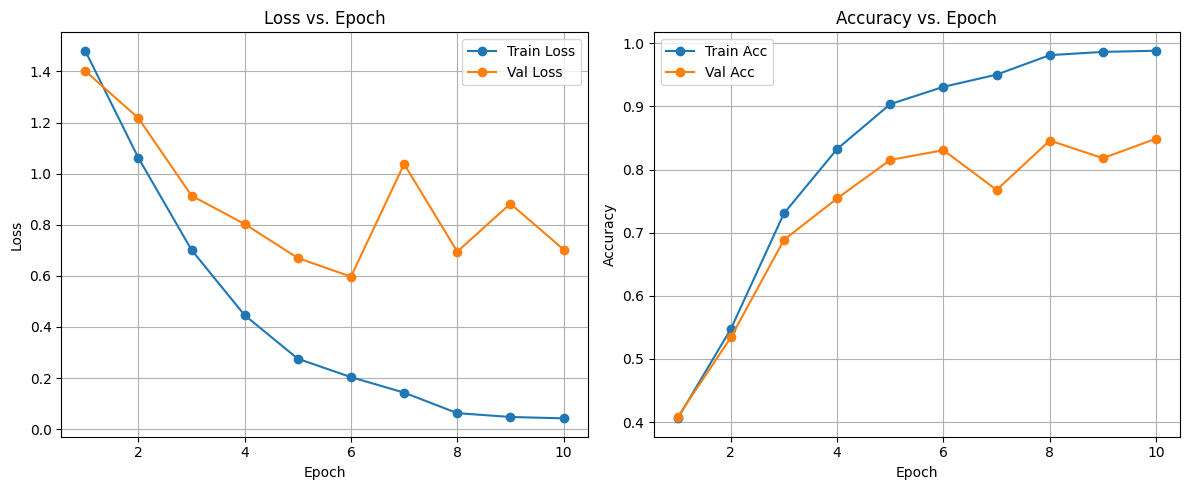

In [51]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, 11, 1)

train_loss = [1.4810, 1.0619, 0.7017, 0.4460, 0.2757, 0.2038, 0.1431, 0.0629, 0.0478, 0.0425]
val_loss   = [1.4017, 1.2176, 0.9138, 0.8029, 0.6698, 0.5969, 1.0377, 0.6948, 0.8825, 0.7030]

train_acc = [0.4058, 0.5474, 0.7307, 0.8326, 0.9037, 0.9311, 0.9504, 0.9813, 0.9864, 0.9883]
val_acc   = [0.4080, 0.5340, 0.6887, 0.7543, 0.8153, 0.8307, 0.7677, 0.8460, 0.8180, 0.8490]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'o-', label='Train Loss')
plt.plot(epochs, val_loss, 'o-', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'o-', label='Train Acc')
plt.plot(epochs, val_acc, 'o-', label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()